<a href="https://colab.research.google.com/github/Zakibrahmi/dataAnalysis/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorail, I will explore how to use build XGBoost for Regression task using Python. The goal of this project is to  to predict diamond prices using their physical measurements; hence, the target feature is *price*.

The first step is to **install** XGBoost. Don't warrry XGBoost can be installed like any python package: pip install xgboost.

It is important to notice that we going with the n**ative API of XGBoost**, rather than its Scikit-learn API :)

While, I m using google Calab, maybe I need juste to upgrade it:



In [1]:
!pip install --upgrade xgboost

**A good start, is to exploring the Datasat**

 The Diamonds dataset is built into the Seaborn library. Also, it is possible to download it from Kaggle (https://www.kaggle.com/datasets/shivam2503/diamonds). Note: Seaborn comes with a few built-in datasets for demonstration and practice purposes. These datasets are readily available and can be loaded using the seaborn.load_dataset() function.


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
diamonds = sns.load_dataset("diamonds")
diamonds.head() #showing only the first 5 rows


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
diamonds.shape

(53940, 10)

A fondamental step in training Model is the cleaning of the dataset(e.g., romobing missing values, ouliers, etc.), but in this dataset comes built-in to Seaborn, it is relatively clean. But, no problem to take a look :)

In [5]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


So, according to the resut of description, we can say:
1. **No Missing Values**: All numerical features have 53940 non-missing values, indicating a complete dataset in this regard.
2. **Potential Outliers**: Features like 'price', 'carat', 'x', 'y', and 'z' show a significant difference between the 75th percentile and the maximum value, suggesting potential outliers.
3. **Skewness:** 'carat' and 'price' likely have right-skewed distributions, indicated by the mean being greater than the median.
4. **Variability:** 'price' has a high standard deviation, showing a wide range of diamond prices in the dataset.

**Categorical features:**


In [3]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = diamonds.drop('price', axis=1), diamonds[['price']]
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [4]:
X.dtypes

,0
carat,float64
cut,category
color,category
clarity,category
depth,float64
table,float64
x,float64
y,float64
z,float64


As we see cut, color, and clarity are categorical features. Don't warry, XGBoost has the ability to internally deal with categoricals

**Skewness handling**
Skewness is a statistical measure that describes the asymmetry of the *probability distribution* of a dataset.

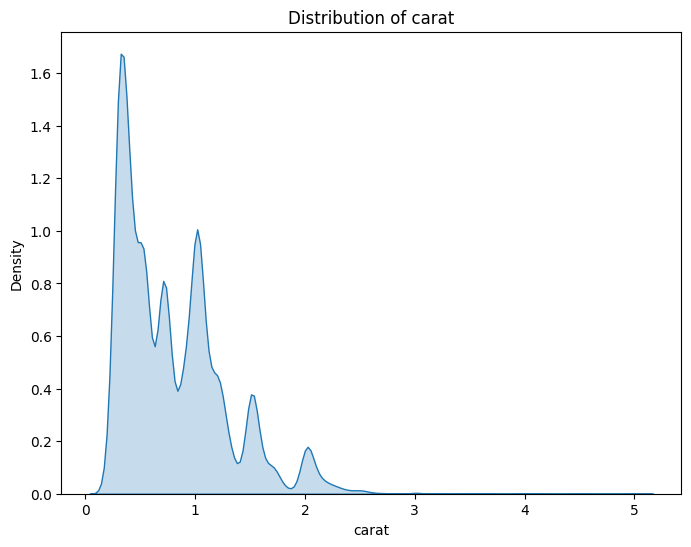

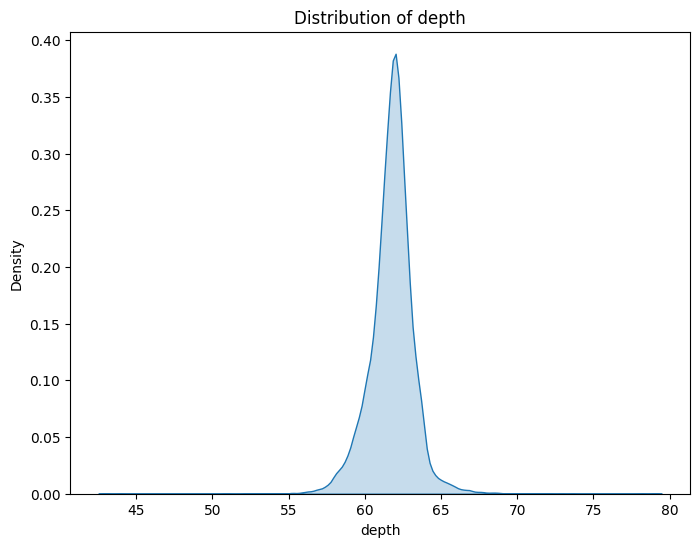

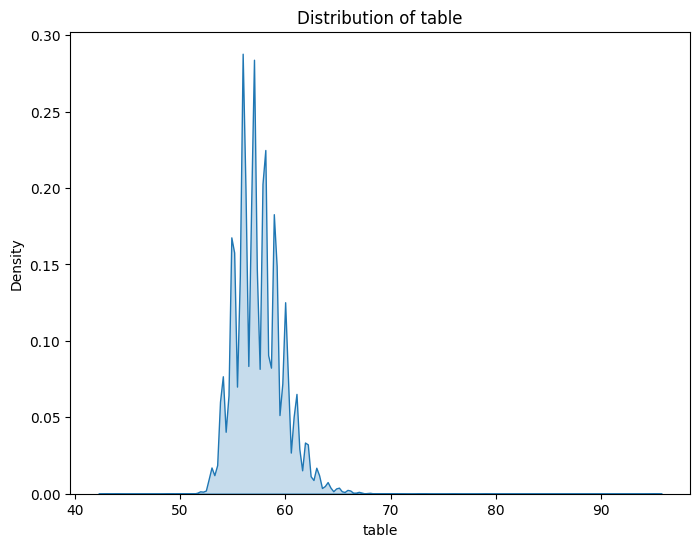

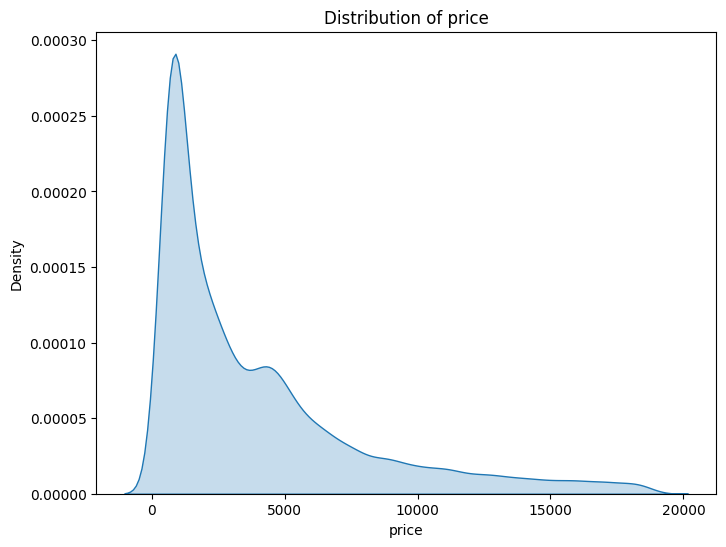

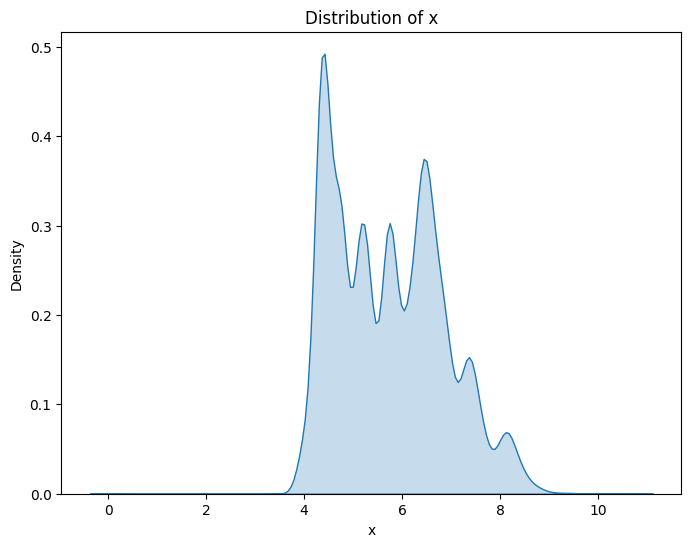

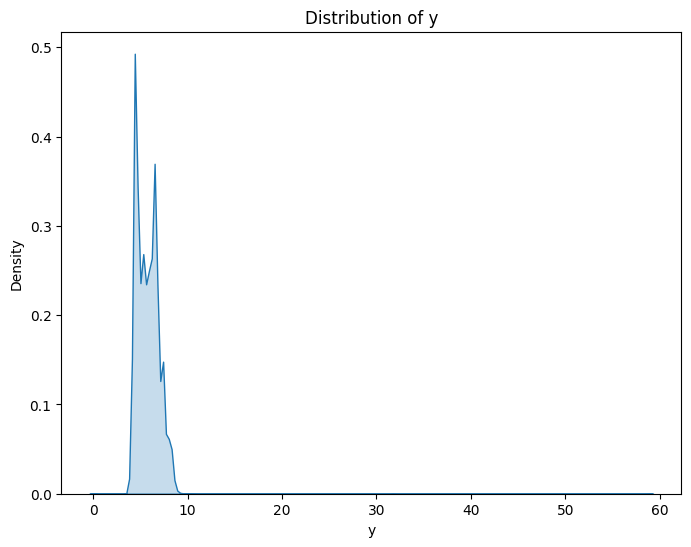

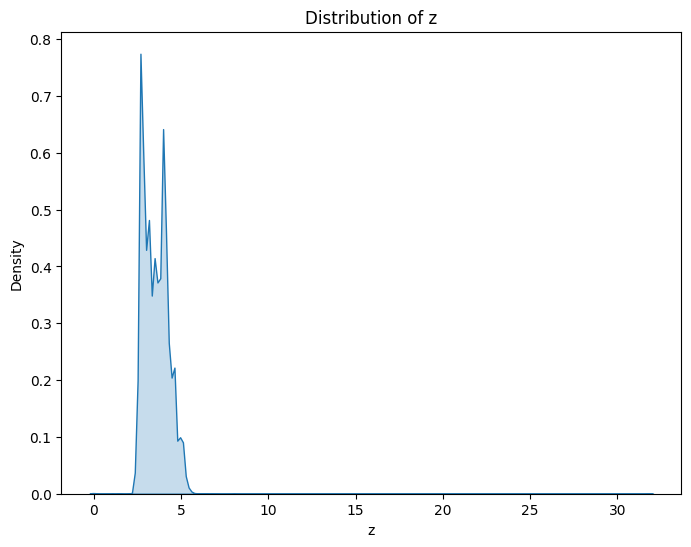

In [11]:
import matplotlib.pyplot as plt

numerical_features = diamonds.select_dtypes(include=np.number).columns

for feature in numerical_features:
       plt.figure(figsize=(8, 6))  # Adjust figure size as needed
       sns.kdeplot(diamonds[feature], shade=True)  # shade=True fills the area under the curve
       plt.title(f'Distribution of {feature}')
       plt.xlabel(feature)
       plt.ylabel('Density')
       plt.show()



It's clear that, for example, the price feature  distribution is *right-skewed*, indicating most diamonds are priced below $5,000, while only a few exceed this price. The same obseration for cart feature also :)

We can use also  scipy's stats to check skewness.

In [176]:
from scipy.stats import skew
skew(diamonds["price"])

1.6183502776053016

1.6183502776053016 value indicates positive skewness which means that our mean is greater than the median. The best value is close de 0 :)


To handel skewness, many transformation methods exist such as: Yeo-Johnson, Box-Cox, Square Root, and Log. I will use, for 'price' feature, which is right-skewed and always positive, the **log transformation** is generally a good starting point.

**But** the transformations should be applied to the *training set* and then propagated to the validation and test sets.

In [192]:
#Function to check skewness of a set features and then apply log transformation.
# a feature is considered skewness if it skew is greater than threshoudl
def skewnes_log(features, data, threshoudl=0.5):
  skewed_features = {}
  skewed_columns = []
  for feature in features:
      skewness = data[feature].skew()
      skewed_features[feature] = skewness
      if skewness > threshoudl:
          print(f"{feature} is right skewed with skewness: {skewness}")

  for feature in features:
      if skewed_features[feature] > threshoudl:
          skewed_columns.append(feature)
          data[feature] = np.log1p(data[feature])


Split dataset into train, and test sets.

In [221]:
# Split the data
from sklearn.model_selection import train_test_split

X = diamonds.drop('price', axis=1)
y = diamonds['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#wzreact only numerical features
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

print(y_test)



1388      559
50052    2201
41645    1238
42377    1304
17244    6901
         ... 
44081    1554
23713     633
31375     761
21772    9836
4998     3742
Name: price, Length: 10788, dtype: int64


In [218]:
#skewnes_log(features=numerical_features, data=X_train, threshoudl=1)

In [219]:
#check again skewness
for feature in numerical_features:
      skewness = X_train[feature].skew()
      if skewness > 1:
          print(f"{feature} is right skewed with skewness: {skewness}")

In [199]:
#skewnes_log(features=numerical_features, data=X_test, threshoudl=1)
#y_test = np.log1p(y_test)
#y_train= np.log1p(y_train)

It's clear that skewess is well reduced, values are acceptable

**Building an XGBoost DMatrix**

XGBoost comes with its own class for storing datasets called **DMatrix**. It is a highly optimized class for memory and speed. So, it is better to convert datasets into this format is a requirement for the native XGBoost API.

Don't forget to set *enable_categorical to True*  to enable automatic encoding of categorical columns.

In [222]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
print(dtrain_reg.num_col())

9


Deine the loss functions to use to solve the XGBoost the machine learning,problem, while we are working with the native API of XGBoost.

I wille use  **Root Mean Squared Error**, which minimizes the square root of the squared sum of the differences between actual (*ground truth*) and predicted values.

In [223]:
def f(pred, y):
    return np.sqrt(np.mean(np.square(pred - y)))


**Hyperparameters of XGBoost**

In [224]:
# Define hyperparameters
# Setting tree_method to gpu_hist, enables GPU acceleration.
# If you don't have a GPU, you can omit the parameter or set it to hist.
# "objective": "reg:squarederror", specifies that the model will use RMSE as the loss function for regression.

params = {"objective": "reg:squarederror", "tree_method": "hist"}

 A crucial hyperparameter in XGBoost, is **num_boost_round**, which stands for number of boosting rounds. It determines the number of times the boosting algorithm iterates to improve the model's predictions ( minimizes the loss function RMSE). Each round adds a new decision tree to the ensemble, aiming to correct errors made by previous trees.

We can tuning the model to find the best valye of  **num_boost_round**. In this project I will set it to 100:

In [225]:
params = {
    "objective": "reg:squarederror",  # Regression task
    "tree_method": "hist",           # Efficient tree-building method
    "lambda": 1.0,                   # Default L2 regularization
    "alpha": 0.1,                    # L1 regularization
    "max_depth": 6,                  # Limit tree depth
    "min_child_weight": 10,          # Minimum weight in leaf nodes
    "subsample": 0.8,                # Use 80% of samples per tree
    "colsample_bytree": 0.8,         # Use 80% of features per tree
    "learning_rate": 0.05          # Reduce learning rate for better generalization

}

n = 1000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=250,
   early_stopping_rounds=50
)


[0]	validation-rmse:3806.21396	train-rmse:3809.70100
[250]	validation-rmse:527.85025	train-rmse:455.65257
[500]	validation-rmse:532.07644	train-rmse:411.14049
[750]	validation-rmse:535.17892	train-rmse:378.66335
[999]	validation-rmse:538.45678	train-rmse:355.33089


We can use *model.get_score()*  to check the importance of each feature in the model's prediction process.

In [161]:
model.get_score()

{'carat': 3975.0,
 'cut': 2595.0,
 'color': 5060.0,
 'clarity': 4195.0,
 'depth': 7564.0,
 'table': 3595.0,
 'x': 4165.0,
 'y': 4431.0,
 'z': 4206.0}

W can set the paramter *importance_type*  to  *gain* (or cover), to obtain the importance score represents the average gain across all splits the feature is used in.

In [216]:
importance_scores = model.get_score(importance_type='gain')
print(importance_scores)

{'carat': 33.267799377441406, 'cut': 0.2510412931442261, 'color': 1.0807256698608398, 'clarity': 2.2384531497955322, 'depth': 0.049334973096847534, 'table': 0.03508565202355385, 'x': 3.2657458782196045, 'y': 31.095237731933594, 'z': 1.9081486463546753}


**Model Evaluation**
In the stage, it is important and like any other ML model,  we must measure its performance by testing it on **unseen** data. Don't forget we have already split our data into train and test data :)

In [226]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg) #predicted/infered value by fitting test values to the model
# Herein, RMSE is used to measure overall performance of the model
calculated_rmse = f(preds, y_test)

print(f"RMSE of the base model: {calculated_rmse:.3f}")


RMSE of the base model: 538.457
